# **Data Preparation**

https://github.com/chintan1995/Image-Denoising-using-Deep-Learning/blob/main/Models/PRIDNet_256x256.ipynb

In [1]:

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
import pathlib
from matplotlib import pyplot as plt
import numpy as np
import cv2
import tensorflow as tf

tf.config.set_visible_devices([], 'GPU')

from tqdm.notebook import tqdm
import random

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [56]:
from sklearn.model_selection import train_test_split
from data_importer import load_training_images

noisy_array, gt_array = load_training_images('../../../../../Dataset/LowDoseCTGrandChallenge/Training_Image_Data/', load_limited_images=True, num_images_to_load=10)

_n, _g = load_training_images('../../../../../Dataset/LowDoseCTGrandChallenge/Selected_Image_Pairs/', load_limited_images=False)

noisy_array = np.concatenate((noisy_array, _n), axis=0)
gt_array = np.concatenate((gt_array, _g), axis=0)

noisy_train, noisy_test, gt_train, gt_test = train_test_split(noisy_array, gt_array, test_size=0.20, random_state=42)


loaded training images x and y of len :  10 10  respectively
type of train images x :  float64
range of values in train images :  0.00024292900950869962 0.5327063878979414
type of train images y :  float64
loaded training images x and y of len :  4 4  respectively
type of train images x :  float64
range of values in train images :  0.0 0.8479930960036455
type of train images y :  float64


In [57]:
print(noisy_train.shape)
print(noisy_test.shape)
print(gt_train.shape)
print(gt_test.shape)

(11, 256, 256, 1)
(3, 256, 256, 1)
(11, 256, 256, 1)
(3, 256, 256, 1)


In [58]:
noisy_train_images = noisy_train
noisy_test_images = noisy_test

gt_train_images = gt_train
gt_test_images = gt_test

print(noisy_train_images.shape)
print(noisy_test_images.shape)

print(gt_train_images.shape)
print(gt_test_images.shape)

(11, 256, 256, 1)
(3, 256, 256, 1)
(11, 256, 256, 1)
(3, 256, 256, 1)


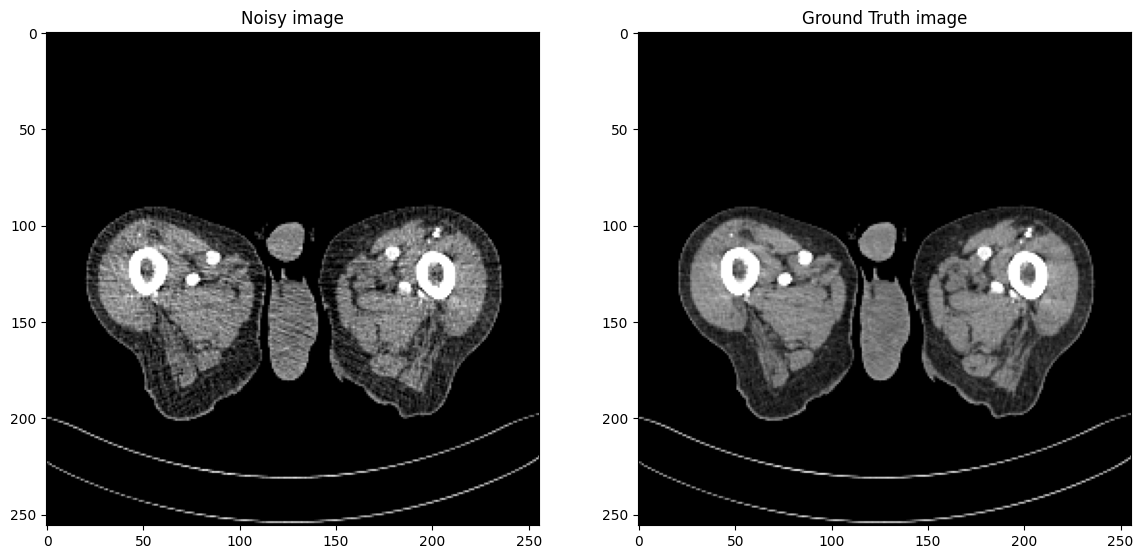

In [59]:
from data_importer import denormalize, trunc

f, axarr = plt.subplots(1,2, figsize=(14,14))
axarr[0].imshow(trunc(denormalize(noisy_train_images[5])), vmin=-160.0, vmax=240.0, cmap='gray')
axarr[0].set_title("Noisy image")
axarr[1].imshow(trunc(denormalize(gt_train_images[5])), vmin=-160.0, vmax=240.0, cmap='gray')
axarr[1].title.set_text("Ground Truth image")

In [7]:
def _up_down_flip(image, label):
    image = tf.image.flip_up_down(image)
    label = tf.image.flip_up_down(label)
    return image, label

def _left_right_flip(image, label):
    image = tf.image.flip_left_right(image)
    label = tf.image.flip_left_right(label)
    return image, label

def _rotate(image, label):
    random_angle = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, random_angle)
    label = tf.image.rot90(label, random_angle)
    return image, label

def _hue(image, label):
    rand_value = random.uniform(-1,1)
    image = tf.image.adjust_hue(image, rand_value)
    label = tf.image.adjust_hue(label, rand_value)
    return image, label

def _brightness(image, label):
    rand_value = random.uniform(-0.08,0.25)
    image = tf.image.adjust_brightness(image, rand_value)
    label = tf.image.adjust_brightness(label, rand_value)
    return image, label

def _saturation(image, label):
    rand_value = random.uniform(1, 5)
    image = tf.image.adjust_saturation(image, rand_value)
    label = tf.image.adjust_saturation(label, rand_value)
    return image, label

def _contrast(image, label):
    rand_value = random.uniform(1, 3)
    image = tf.image.adjust_contrast(image, rand_value)
    label = tf.image.adjust_contrast(label, rand_value)
    return image, label

# What does batch, repeat, and shuffle do with TensorFlow Dataset?
# https://stackoverflow.com/q/53514495/7697658
def tf_data_generator(X, y, batch_size=32, augmentations=None):
    dataset = tf.data.Dataset.from_tensor_slices((X, y)) # This is the main step for data generation
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)

    if augmentations:
        for f in augmentations:
            if np.random.uniform(0,1)<0.5:
                dataset = dataset.map(f, num_parallel_calls=2)

    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

BATCH_SIZE=4
# augmentation_lst = [_up_down_flip, _left_right_flip, _rotate, _hue, _brightness, _saturation, _contrast]
augmentation_lst = [_up_down_flip, _left_right_flip, _rotate]
image_generator_train = tf_data_generator(X=noisy_train_images, y=gt_train_images, batch_size=BATCH_SIZE, augmentations=augmentation_lst)
image_generator_test = tf_data_generator(X=noisy_test_images, y=gt_test_images, batch_size=BATCH_SIZE)

In [8]:
image_generator_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(4, 256, 256, 1), dtype=tf.float64, name=None), TensorSpec(shape=(4, 256, 256, 1), dtype=tf.float64, name=None))>

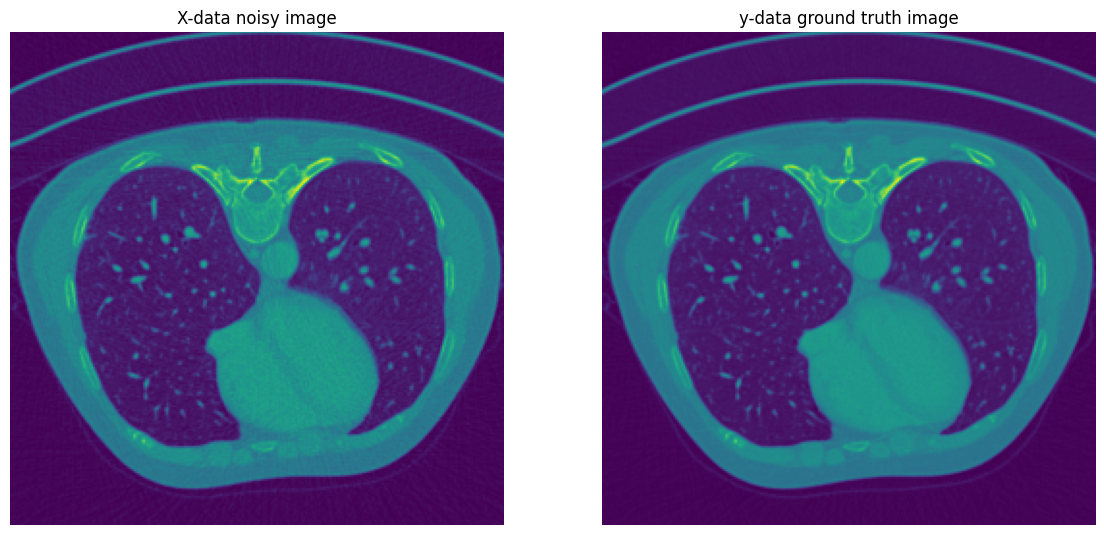

In [9]:
# SANITY CHECK of the Dataset generator
for noisy, gt in image_generator_train.take(1):  # only take first element of dataset
    numpy_images = noisy.numpy()
    numpy_labels = gt.numpy()

f, axarr = plt.subplots(1,2, figsize=(14,14))
axarr[0].imshow(numpy_images[1])
axarr[0].set_title("X-data noisy image")
axarr[0].set_axis_off()

axarr[1].imshow(numpy_labels[1])
axarr[1].set_title("y-data ground truth image")
axarr[1].set_axis_off()

# **PRIDNet**
<a href='https://arxiv.org/pdf/1908.00273.pdf'>https://arxiv.org/pdf/1908.00273.pdf</a>


In [10]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,\
                                    GlobalAveragePooling2D, AveragePooling2D, MaxPool2D, UpSampling2D,\
                                    BatchNormalization, Activation, Flatten, Dense, Input,\
                                    Add, Multiply, Concatenate, concatenate, Softmax
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import softmax

tf.keras.backend.set_image_data_format('channels_last')

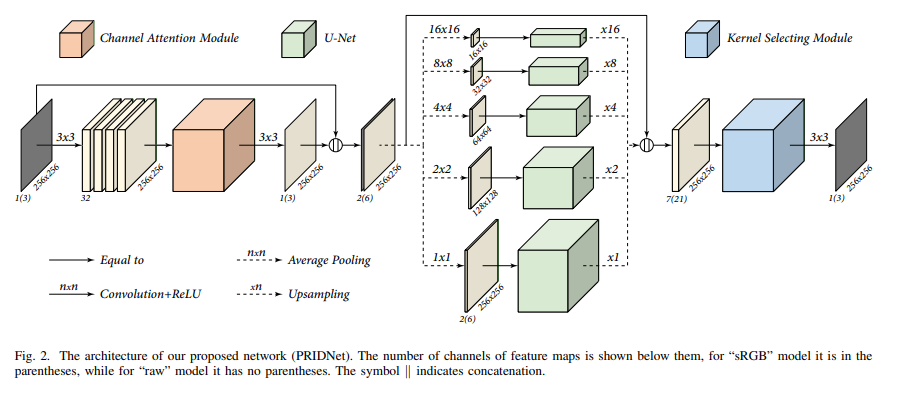

In [11]:
class Convolutional_block(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')
        self.conv_2 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')
        self.conv_3 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')
        self.conv_4 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same')

    def call(self, X):
        X_1 = self.conv_1(X)
        X_1 = Activation('relu')(X_1)

        X_2 = self.conv_2(X_1)
        X_2 = Activation('relu')(X_2)

        X_3 = self.conv_3(X_2)
        X_3 = Activation('relu')(X_3)

        X_4 = self.conv_4(X_3)
        X_4 = Activation('relu')(X_4)
        
        #print('---conv block=',X_4.shape)
        
        return X_4

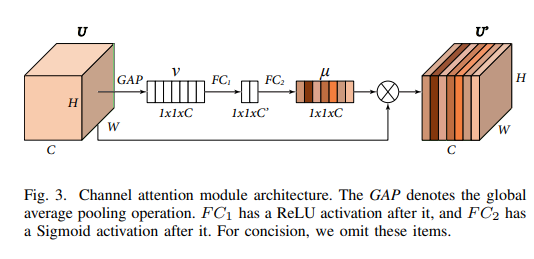

In [12]:
class Channel_attention(tf.keras.layers.Layer):
    def __init__(self, C=64, **kwargs):
        super().__init__(**kwargs)
        self.C=C
        self.gap = GlobalAveragePooling2D()
        self.dense_middle = Dense(units=2, activation='relu')
        self.dense_sigmoid = Dense(units=self.C, activation='sigmoid')
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'C': self.C
        })
        return config

    def call(self, X):
        v = self.gap(X)
        #print("ca_ after gap =",v.shape)
        fc1 = self.dense_middle(v)
        #print("ca_ after fc1 =",fc1.shape)
        mu = self.dense_sigmoid(fc1)
        #print("ca_ after fc2 =",mu.shape)

        U_out = Multiply()([X, mu])
        
        #print('---channel attention block=',U_out.shape)

        return U_out

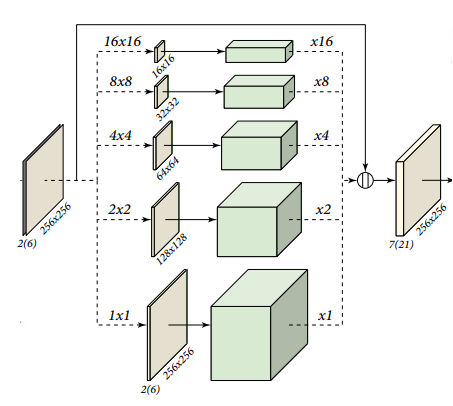

In [13]:
class Avg_pool_Unet_Upsample_msfe(tf.keras.layers.Layer):
    def __init__(self, avg_pool_size, upsample_rate, **kwargs):
        super().__init__(**kwargs)
        # ---initialization for Avg pooling---
        self.avg_pool = AveragePooling2D(pool_size=avg_pool_size, padding='same')

        # --- initialization for Unet---
        self.deconv_lst = []
        filter=512
        for i in range(4):
            self.deconv_lst.append(Conv2DTranspose(filters=filter/2, kernel_size=[3, 3], strides=2, padding='same'))
            filter/=2

        self.conv_32_down_lst = []
        for i in range(4):
            self.conv_32_down_lst.append(Conv2D(filters=64, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_64_down_lst = []
        for i in range(4):
            self.conv_64_down_lst.append(Conv2D(filters=128, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_128_down_lst = []
        for i in range(4):
            self.conv_128_down_lst.append(Conv2D(filters=256, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_256_down_lst = []
        for i in range(4):
            self.conv_256_down_lst.append(Conv2D(filters=512, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_512_down_lst = []
        for i in range(4):
            self.conv_512_down_lst.append(Conv2D(filters=1024, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))


        self.conv_32_up_lst = []
        for i in range(3):
            self.conv_32_up_lst.append(Conv2D(filters=64, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_64_up_lst = []
        for i in range(3):
            self.conv_64_up_lst.append(Conv2D(filters=128, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_128_up_lst = []
        for i in range(3):
            self.conv_128_up_lst.append(Conv2D(filters=256, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))

        self.conv_256_up_lst = []
        for i in range(3):
            self.conv_256_up_lst.append(Conv2D(filters=512, kernel_size=[3, 3], activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=0.001)))


        self.conv_3 = Conv2D(filters=3, kernel_size=[1, 1])

        self.pooling1_unet = MaxPool2D(pool_size=[2, 2], padding='same')
        self.pooling2_unet = MaxPool2D(pool_size=[2, 2], padding='same')
        self.pooling3_unet = MaxPool2D(pool_size=[2, 2], padding='same')
        self.pooling4_unet = MaxPool2D(pool_size=[2, 2], padding='same')

        # ---initialization for Upsampling---
        self.upsample = UpSampling2D(upsample_rate, interpolation='bilinear')
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'avg_pool_size': self.avg_pool_size,
            'upsample_rate':self.upsample_rate
        })
        return config

    def upsample_and_concat(self, x1, x2, i):
        deconv = self.deconv_lst[i](x1)
        deconv_output = Concatenate()([deconv, x2])
        return deconv_output

    def unet(self, input):
        # ---Unet downsampling---
        conv1 = input
        for c_32 in self.conv_32_down_lst:
            conv1 = c_32(conv1)
        pool1 = self.pooling1_unet(conv1)

        conv2 = pool1
        for c_64 in self.conv_64_down_lst:
            conv2 = c_64(conv2)
        pool2 = self.pooling2_unet(conv2)

        conv3 = pool2
        for c_128 in self.conv_128_down_lst:
            conv3 = c_128(conv3)
        pool3 = self.pooling3_unet(conv3)

        conv4 = pool3
        for c_256 in self.conv_256_down_lst:
            conv4 = c_256(conv4)
        pool4 = self.pooling4_unet(conv4)

        conv5 = pool4
        for c_512 in self.conv_512_down_lst:
            conv5 = c_512(conv5)

        # ---Unet upsampling---
        up6 = self.upsample_and_concat(conv5, conv4, 0)
        conv6 = up6
        for c_256 in self.conv_256_up_lst:
            conv6 = c_256(conv6)

        up7 = self.upsample_and_concat(conv6, conv3, 1)
        conv7 = up7
        for c_128 in self.conv_128_up_lst:
            conv7 = c_128(conv7)

        up8 = self.upsample_and_concat(conv7, conv2, 2)
        conv8 = up8
        for c_64 in self.conv_64_up_lst:
            conv8 = c_64(conv8)

        up9 = self.upsample_and_concat(conv8, conv1, 3)
        conv9 = up9
        for c_32 in self.conv_32_up_lst:
            conv9 = c_32(conv9)

        conv10 = self.conv_3(conv9)
        return conv10

    def call(self, X):
        avg_pool = self.avg_pool(X)
        #print("ap =",avg_pool.shape)
        unet = self.unet(avg_pool)
        upsample = self.upsample(unet)
        return upsample

In [14]:
class Multi_scale_feature_extraction(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.msfe_16 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=16, upsample_rate=16)
        self.msfe_8 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=8, upsample_rate=8)
        self.msfe_4 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=4, upsample_rate=4)
        self.msfe_2 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=2, upsample_rate=2)
        self.msfe_1 = Avg_pool_Unet_Upsample_msfe(avg_pool_size=1, upsample_rate=1)

    def call(self, X):
        up_sample_16 = self.msfe_16(X)
        up_sample_8 = self.msfe_8(X)
        up_sample_4 = self.msfe_4(X)
        up_sample_2 = self.msfe_2(X)
        up_sample_1 = self.msfe_1(X)
        msfe_out = Concatenate()([X, up_sample_16, up_sample_8, up_sample_4, up_sample_2, up_sample_1])

        #print('---Multi scale feature extraction block=',msfe_out.shape)
        return msfe_out

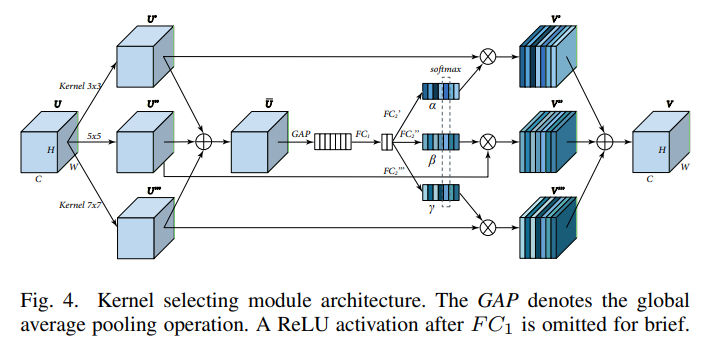

In [15]:
class Kernel_selecting_module(tf.keras.layers.Layer):
    def __init__(self, C=21, **kwargs):
        super().__init__(**kwargs)
        self.C = C
        self.c_3 = Conv2D(filters=self.C, kernel_size=(3,3), strides=1, padding='same', kernel_regularizer=regularizers.l2(l2=0.001))
        self.c_5 = Conv2D(filters=self.C, kernel_size=(5,5), strides=1, padding='same', kernel_regularizer=regularizers.l2(l2=0.001))
        self.c_7 = Conv2D(filters=self.C, kernel_size=(7,7), strides=1, padding='same', kernel_regularizer=regularizers.l2(l2=0.001))
        self.gap = GlobalAveragePooling2D()
        self.dense_two = Dense(units=2, activation='relu')
        self.dense_c1 = Dense(units=self.C)
        self.dense_c2 = Dense(units=self.C)
        self.dense_c3 = Dense(units=self.C)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'C': self.C
        })
        return config

    def call(self, X):
        X_1 = self.c_3(X)
        X_2 = self.c_5(X)
        X_3 = self.c_7(X)

        X_dash = Add()([X_1, X_2, X_3])

        v_gap = self.gap(X_dash)
        v_gap = tf.reshape(v_gap, [-1, 1, 1, self.C])
        fc1 = self.dense_two(v_gap)

        alpha = self.dense_c1(fc1)
        beta = self.dense_c2(fc1)
        gamma = self.dense_c3(fc1)

        before_softmax = concatenate([alpha, beta, gamma], 1)
        # print(before_softmax.shape)
        after_softmax = softmax(before_softmax, axis=1)
        a1 = after_softmax[:, 0, :, :]
        # print(a1)
        a1 = tf.reshape(a1, [-1, 1, 1, self.C])
        # print(a1)
        a2 = after_softmax[:, 1, :, :]
        a2 = tf.reshape(a2, [-1, 1, 1, self.C])
        a3 = after_softmax[:, 2, :, :]
        a3 = tf.reshape(a3, [-1, 1, 1, self.C])

        select_1 = Multiply()([X_1, a1])
        select_2 = Multiply()([X_2, a2])
        select_3 = Multiply()([X_3, a3])

        out = Add()([select_1, select_2, select_3])

        return out

In [16]:
def create_model():
    # ca_block = Channel Attention block
    # msfe_block = Multi scale feature extraction block
    # ksm = Kernel Selecting Module
    tf.keras.backend.clear_session()

    input = Input(shape=(256,256,1), name="input_layer")
    print("Input =",input.shape)

    conv_block = Convolutional_block()(input)
    print("Conv block =",conv_block.shape)
    ca_block = Channel_attention()(conv_block)
    print("Channel Attention =",ca_block.shape)
    ca_block = Conv2D(filters=3, kernel_size=(3,3), strides=1, padding='same')(ca_block)
    print("Channel Attention Last CNN =",ca_block.shape)
    ca_block = Concatenate()([input, ca_block])
    print("First phase =",ca_block.shape)
    print()

    msfe_block = Multi_scale_feature_extraction()(ca_block)

    print("Multi-scale feature extraction =",msfe_block.shape)

    ksm = Kernel_selecting_module()(msfe_block)
    ksm = Conv2D(filters=3, kernel_size=(3,3), strides=1, padding='same')(ksm)
    print("Kernel Selection Module =",ksm.shape)
    model = Model(inputs=[input], outputs=[ksm])
    return model

model = create_model()
model.summary()


Input = (None, 256, 256, 1)
Conv block = (None, 256, 256, 64)
Channel Attention = (None, 256, 256, 64)
Channel Attention Last CNN = (None, 256, 256, 3)
First phase = (None, 256, 256, 4)


Multi-scale feature extraction = (None, 256, 256, 19)
Kernel Selection Module = (None, 256, 256, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 convolutional_block (Convo  (None, 256, 256, 64)         111424    ['input_layer[0][0]']         
 lutional_block)                                                                                  
                                                                                                  
 ch

In [17]:
tf.keras.utils.plot_model(model=model, to_file='model_plot.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# **Training**

In [18]:
steps_per_epoch_train = len(noisy_train_images)
steps_per_epoch_validation = len(noisy_test_images)

In [19]:
check_point_filepath="full_dataset_saved_weights/hformer_64_channel_custom_loss_epochs_{epoch:02d}.h5"

callbacks_lst = [
                 tf.keras.callbacks.ModelCheckpoint(filepath=check_point_filepath, monitor='val_accuracy', verbose=1, save_best_only=False, save_weights_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=0.0000009, min_delta=0.0001, factor=0.70, patience=3, verbose=1, mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.0001, patience=10)
]

In [20]:
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=Adam(learning_rate=0.0009))


In [57]:
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=Adam(learning_rate=0.0009))
model.fit(image_generator_train, 
          validation_data=image_generator_test,
                        steps_per_epoch=steps_per_epoch_train,
                        validation_steps=steps_per_epoch_validation,
                        epochs=1,
                        verbose=1,
                        callbacks=callbacks_lst)

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x0000020E2AE3AA20>
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.1776.0_x64__qbz5n2kfra8p0\Lib\weakref.py", line 370, in remove
    self = selfref()
           ^^^^^^^^^
KeyboardInterrupt: 


In [ ]:
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=Adam(learning_rate=0.00003))
model.fit(image_generator_train, 
          validation_data=image_generator_test,
                        steps_per_epoch=steps_per_epoch_train,
                        validation_steps=steps_per_epoch_validation,
                        epochs=100,
                        verbose=1,
                        callbacks=callbacks_lst)

Epoch 1/100
241/241 [==============================] - 134s 484ms/step - loss: 46.1316 - val_loss: 61.6144
Epoch 2/100
241/241 [==============================] - 114s 472ms/step - loss: 44.8511 - val_loss: 61.5617
Epoch 3/100
241/241 [==============================] - 114s 472ms/step - loss: 45.5421 - val_loss: 61.7855
Epoch 4/100
241/241 [==============================] - 114s 472ms/step - loss: 44.7381 - val_loss: 62.2653
Epoch 5/100
241/241 [==============================] - 114s 472ms/step - loss: 44.2666 - val_loss: 62.6621

Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.0999999469495376e-05.
Epoch 6/100
241/241 [==============================] - 114s 472ms/step - loss: 44.7718 - val_loss: 62.2223
Epoch 7/100
241/241 [==============================] - 114s 472ms/step - loss: 45.0633 - val_loss: 61.8771
Epoch 8/100
241/241 [==============================] - 114s 472ms/step - loss: 45.4727 - val_loss: 61.6828

Epoch 00008: ReduceLROnPlateau reducing learning rate to 1.46

# **Inference**

In [75]:
# Inference
def inference_single_image(model, noisy_image):
    input_image = np.expand_dims(noisy_image, axis=0)
    predicted_image = model.predict(input_image)
    a = np.abs(np.min(predicted_image))
    b = np.max(predicted_image)
    
    #predicted_image = predicted_image * (b - a) + a
    return predicted_image[0]

In [76]:
def inference_batch_images(model, noisy_images):
    input_image = noisy_images

    predicted_image = model.predict(input_image).astype(np.float64)
    return predicted_image

In [23]:
#best_models_path = "/content/drive/MyDrive/Colab Notebooks/Applied AI Assignments/Case Study 2 Image Denoising/Best Models/PRIDNet model/"
model.summary()
model.load_weights('data/pridnet_epochs_07.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 convolutional_block (Convo  (None, 256, 256, 64)         111424    ['input_layer[0][0]']         
 lutional_block)                                                                                  
                                                                                                  
 channel_attention (Channel  (None, 256, 256, 64)         322       ['convolutional_block[0][0]'] 
 _attention)                                                                                      
                                                                                              

In [68]:
def rgb2gray(rgb):
    return np.expand_dims(np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]), axis=-1)

from skimage.metrics import structural_similarity as ssim
import sys
sys.path.append('../')

from metrics import compute_SSIM, compute_PSNR

def calculate_psnr(original_image, reconstructed_image):
    return compute_PSNR(original_image, reconstructed_image, 240+160.0)

    psnr_value = peak_signal_noise_ratio(original_image, reconstructed_image, data_range=240+160)
    return psnr_value

def calculate_ssim(original_image, reconstructed_image):    
    ssim_value = ssim(original_image.astype(np.float64), reconstructed_image.astype(np.float64), win_size=5,  channel_axis=2, data_range=240+160)
    return ssim_value



def visualize_predictions(model, X_test, y_test, n):
    random_numbers = random.choices(range(X_test.shape[0]), k=n)    # Get n random indices
    for i in random_numbers:
        noisy_image = X_test[i]
        gt_image = y_test[i]
        predicted_image = rgb2gray((inference_single_image(model, X_test[i])).astype(np.float64))  
        
        print('[After Denormalization]')
        print('PSNR of reconsturcted image : ', calculate_psnr(trunc(denormalize(gt_image)), trunc(denormalize(predicted_image))))
        print('PSNR of noisy image : ', calculate_psnr(trunc(denormalize(gt_image)),  trunc(denormalize(noisy_image))))
        print('SSIM of noisy image : ', calculate_ssim(trunc(denormalize(gt_image)), trunc(denormalize(noisy_image))))
        print('SSIM of reconstructed image : ', calculate_ssim(trunc(denormalize(gt_image)),  trunc(denormalize(predicted_image))))
        
        print(predicted_image.shape, noisy_image.shape)       
        f, axarr = plt.subplots(1,3, figsize=(21,21))
        axarr[0].imshow(trunc(denormalize(noisy_image)), cmap='gray', vmin=-160.0, vmax=240.0)
        axarr[0].set_title("Noisy image")
        axarr[0].set_axis_off()
        axarr[1].imshow(trunc(denormalize(gt_image)),  cmap='gray', vmin=-160.0, vmax=240.0)
        axarr[1].set_title("Ground truth image")
        axarr[1].set_axis_off()
        axarr[2].imshow(trunc(denormalize(predicted_image)), cmap='gray', vmin=-160.0, vmax=240.0)
        axarr[2].set_title("Predicted image")
        axarr[2].set_axis_off()

1/1 [==============================] - 1s 1s/step
[After Denormalization]
PSNR of reconsturcted image :  28.754976946695407
PSNR of noisy image :  28.038590669260373
SSIM of noisy image :  0.8399096130149829
SSIM of reconstructed image :  0.8450910735559828
(256, 256, 1) (256, 256, 1)
1/1 [==============================] - 1s 1s/step
[After Denormalization]
PSNR of reconsturcted image :  27.601495247662942
PSNR of noisy image :  27.088638119928817
SSIM of noisy image :  0.8977717864072577
SSIM of reconstructed image :  0.8943497581839652
(256, 256, 1) (256, 256, 1)
1/1 [==============================] - 1s 1s/step
[After Denormalization]
PSNR of reconsturcted image :  28.754976946695407
PSNR of noisy image :  28.038590669260373
SSIM of noisy image :  0.8399096130149829
SSIM of reconstructed image :  0.8450910735559828
(256, 256, 1) (256, 256, 1)
1/1 [==============================] - 1s 1s/step
[After Denormalization]
PSNR of reconsturcted image :  28.132683326464672
PSNR of noisy imag

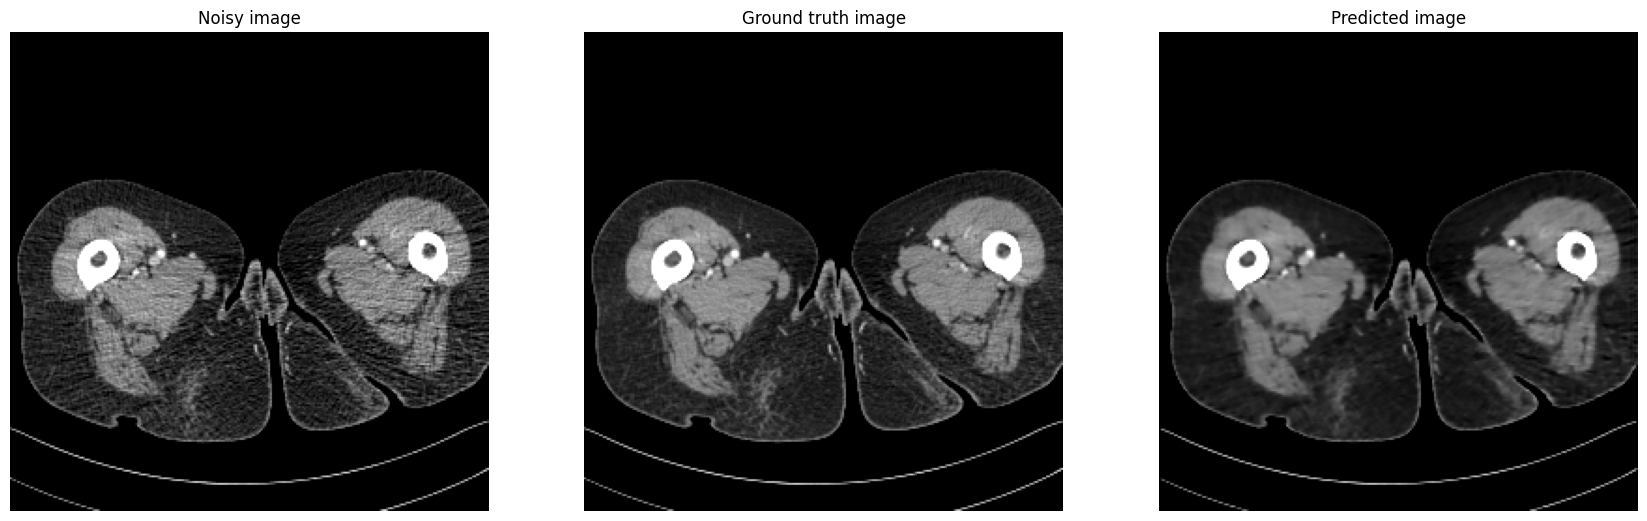

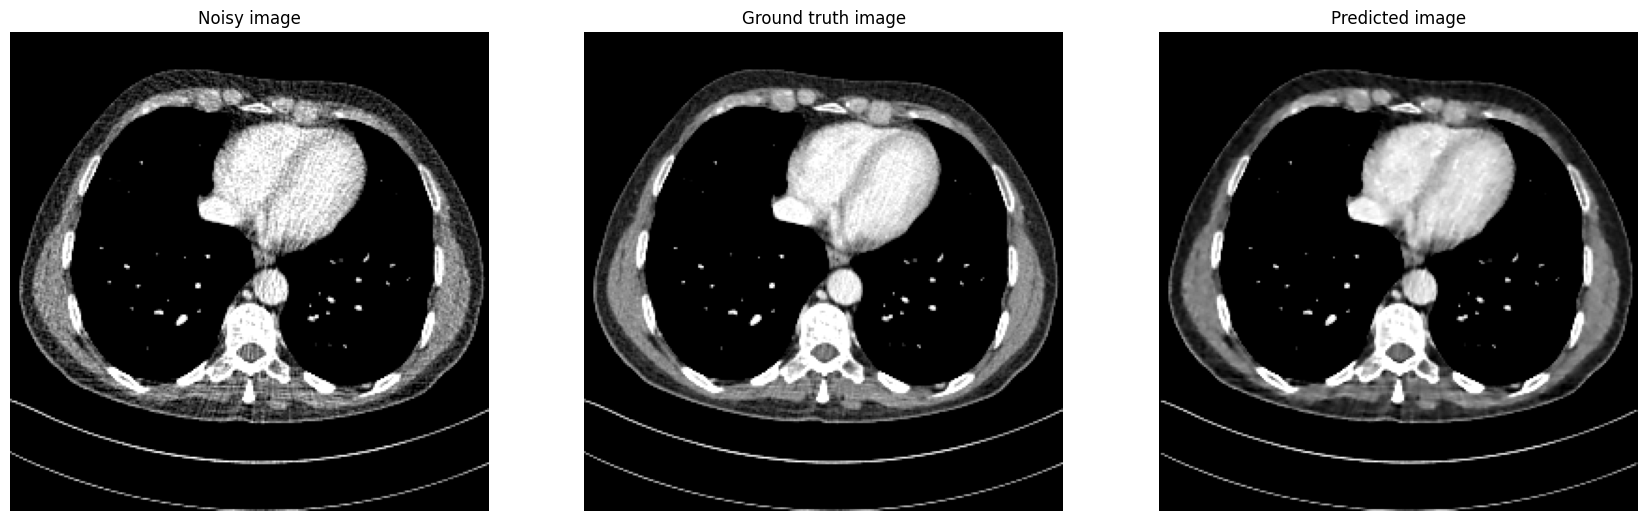

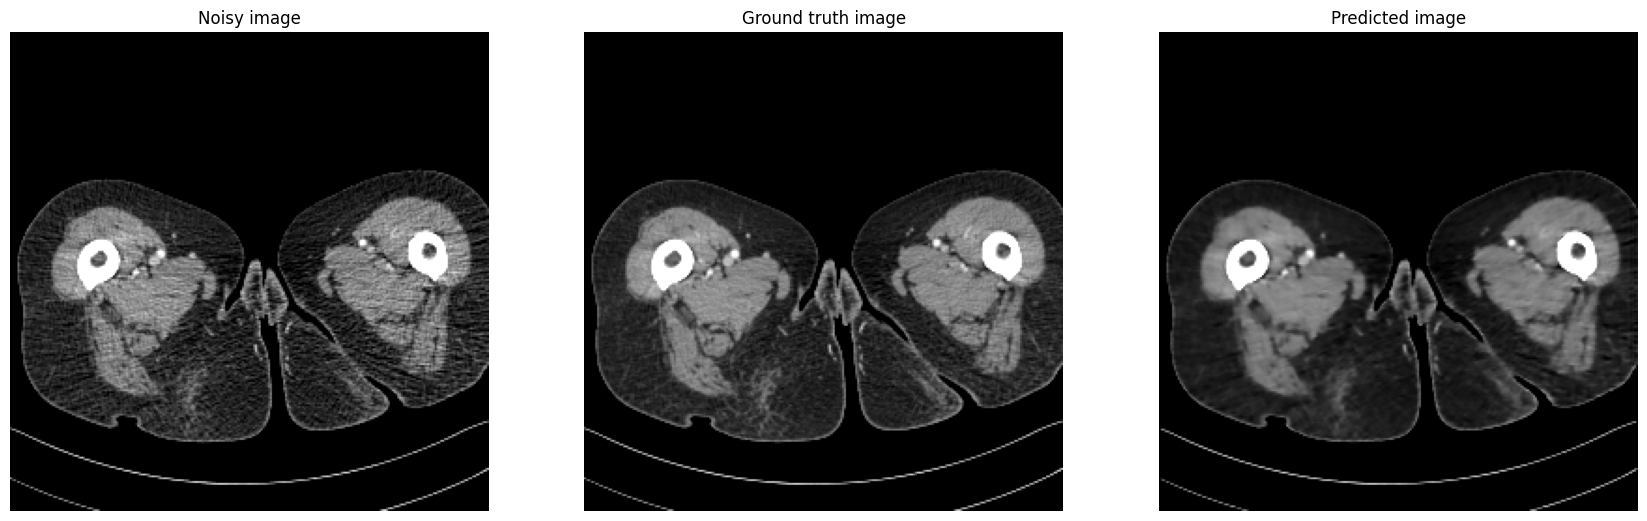

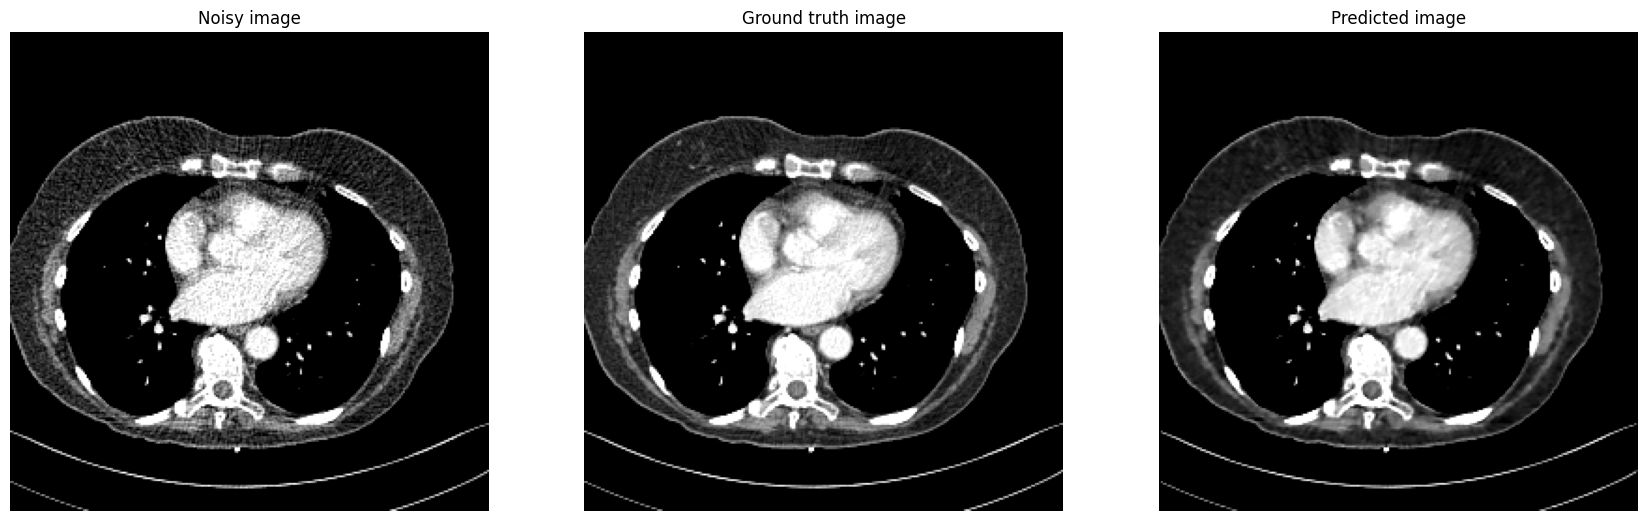

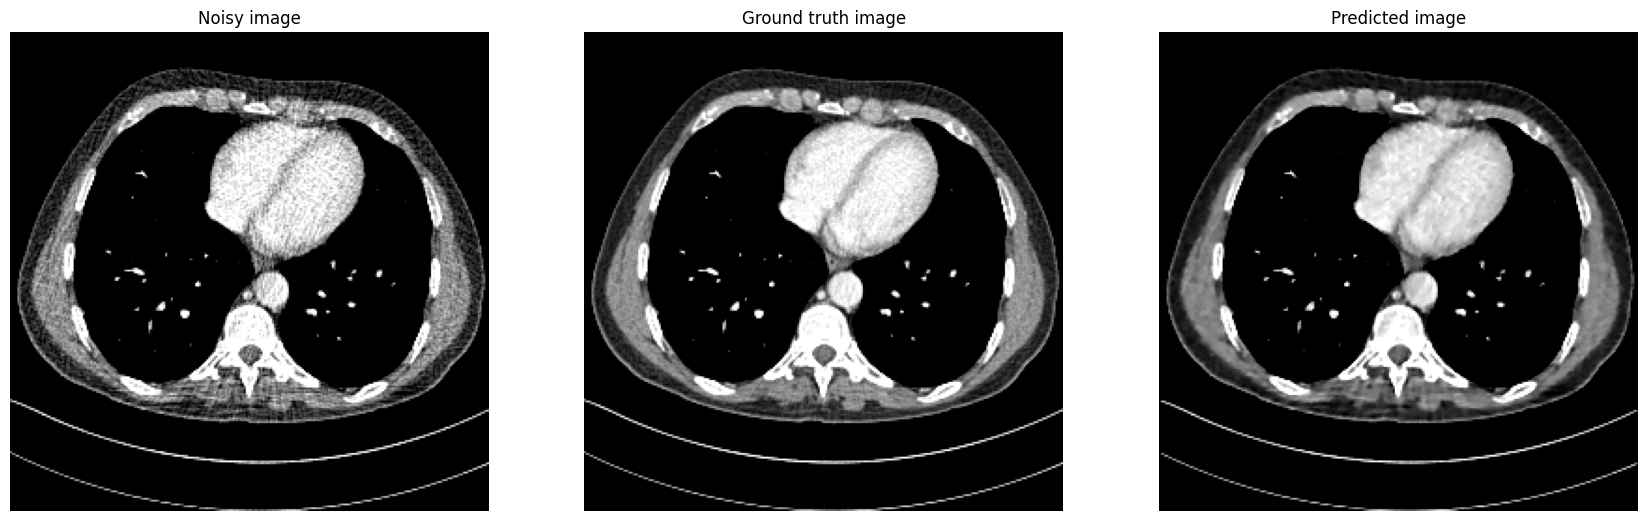

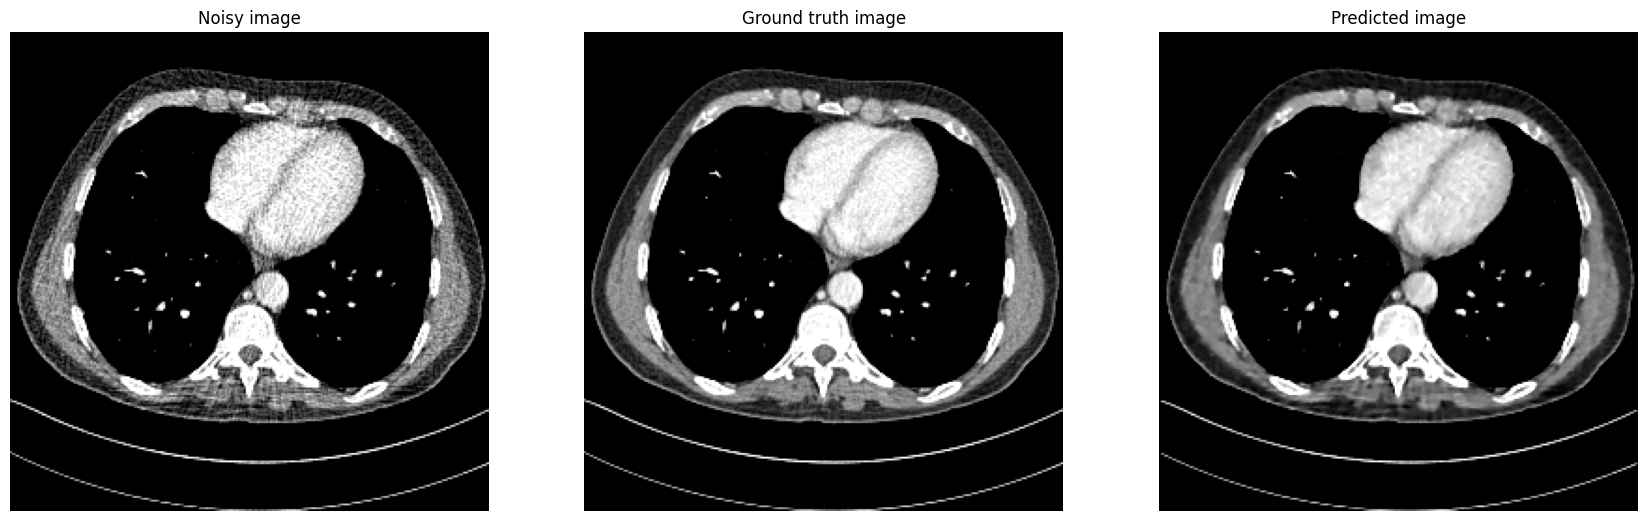

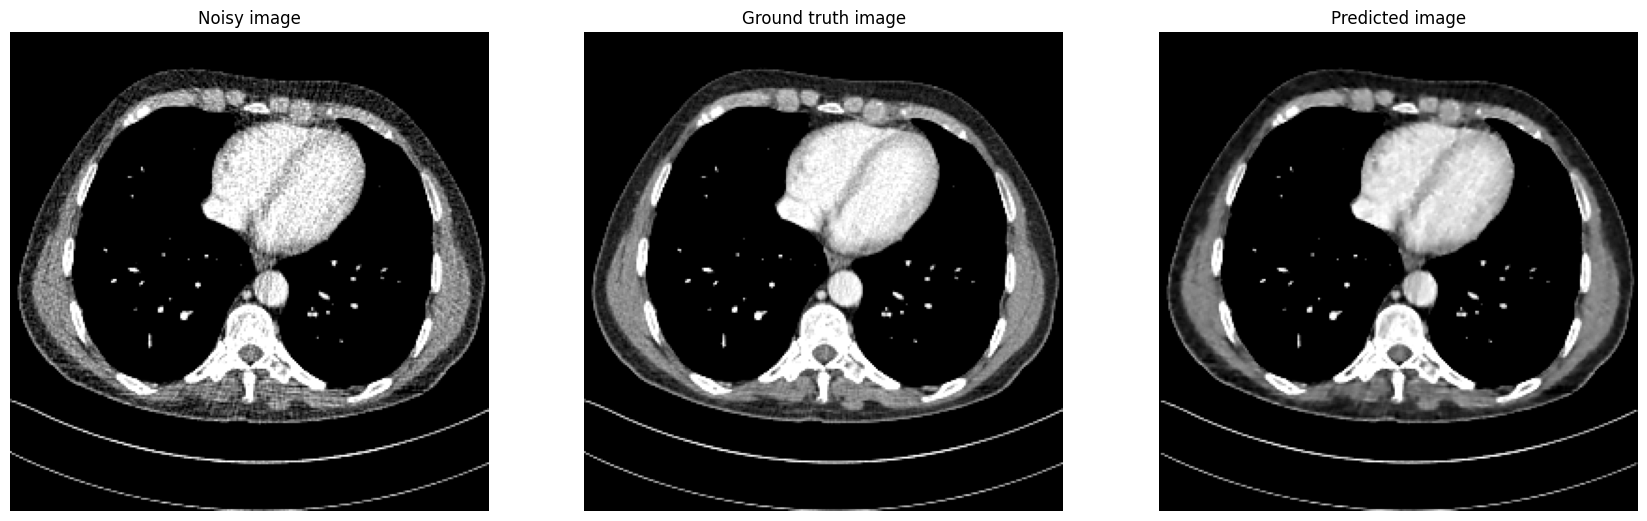

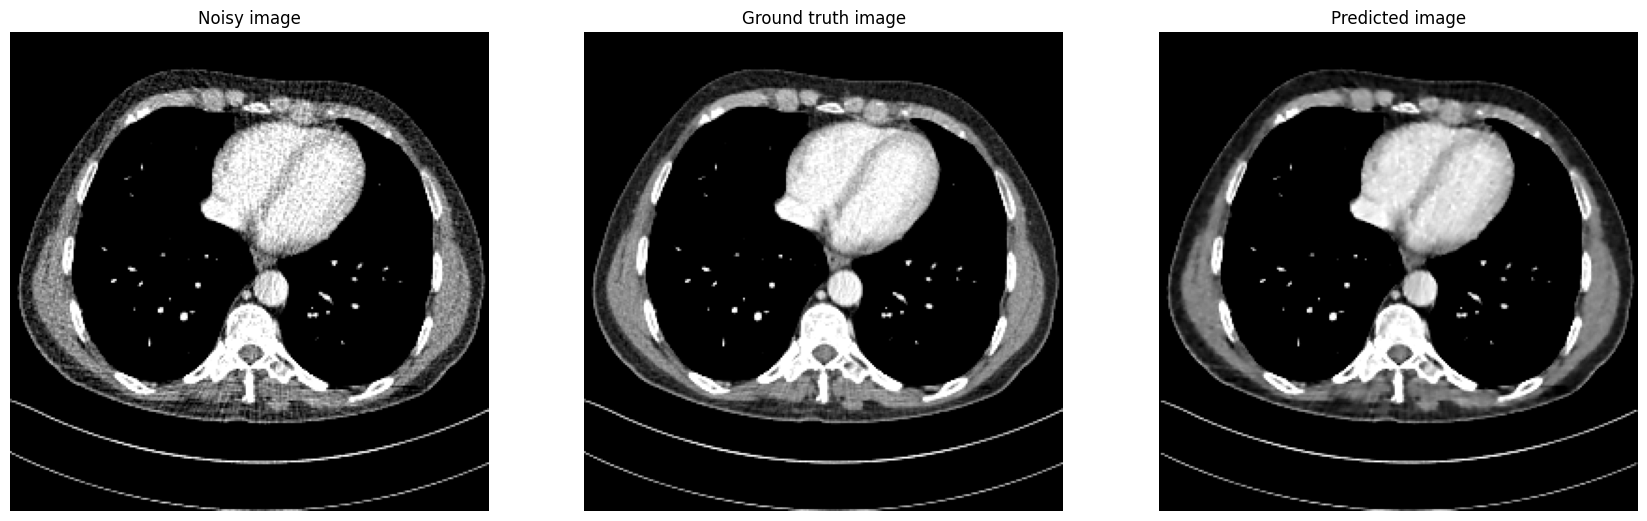

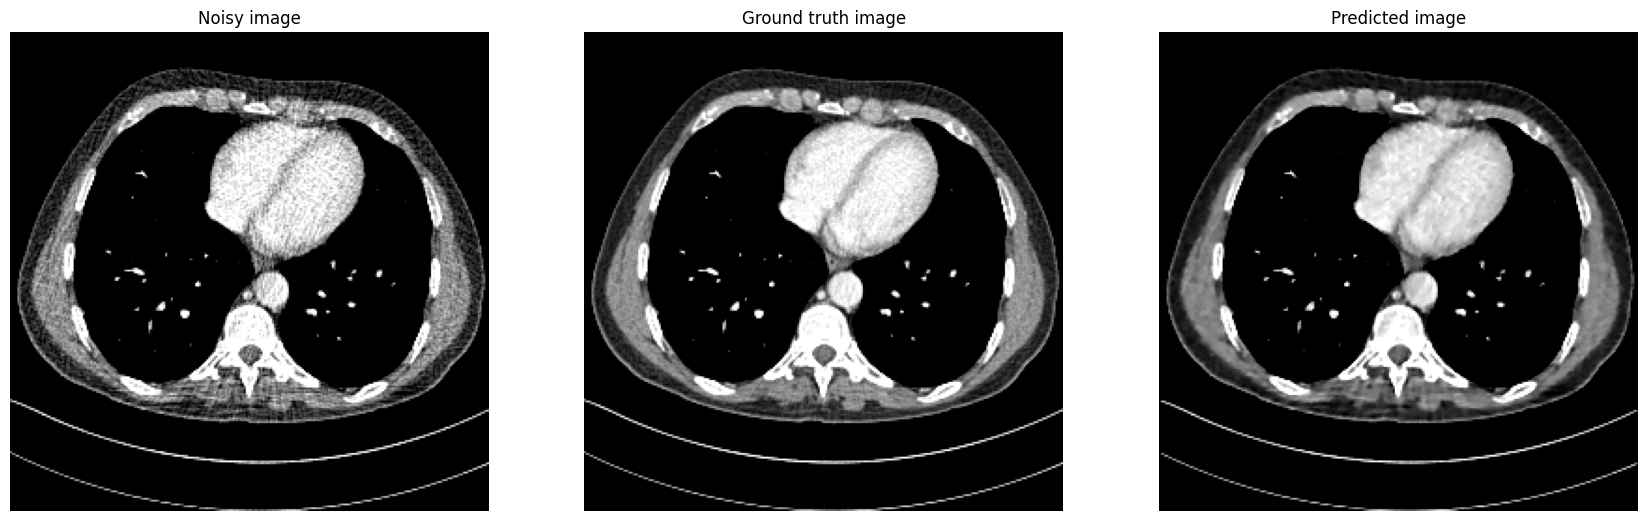

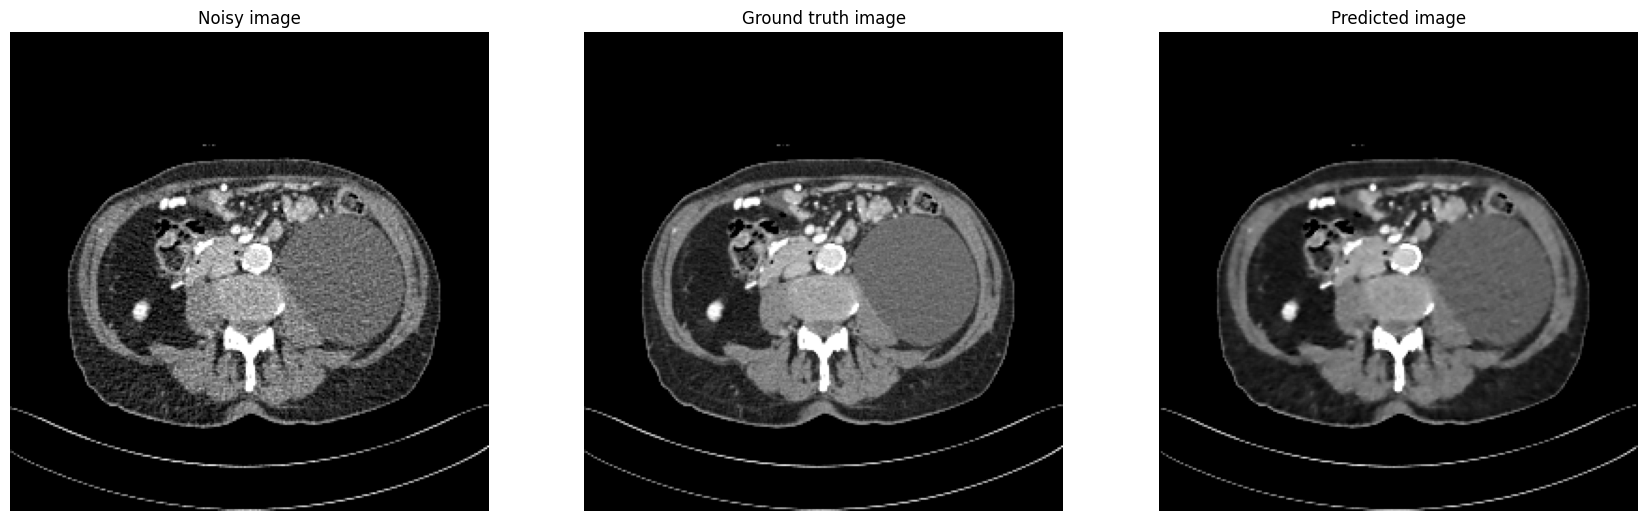

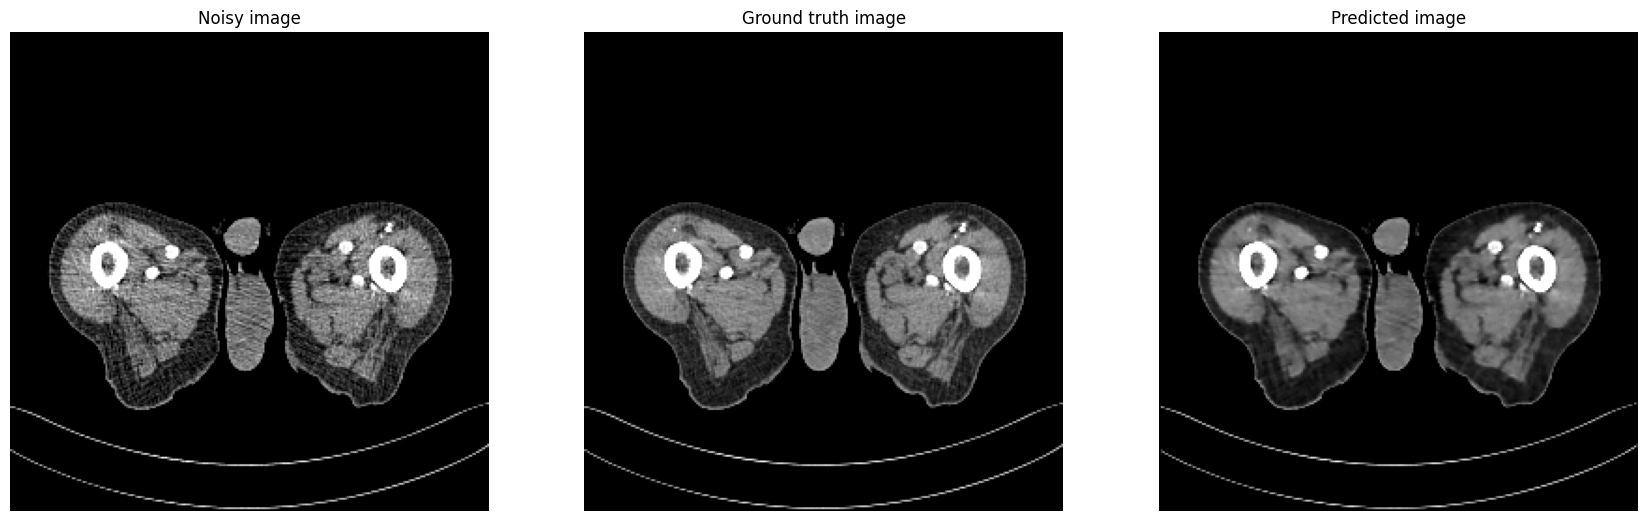

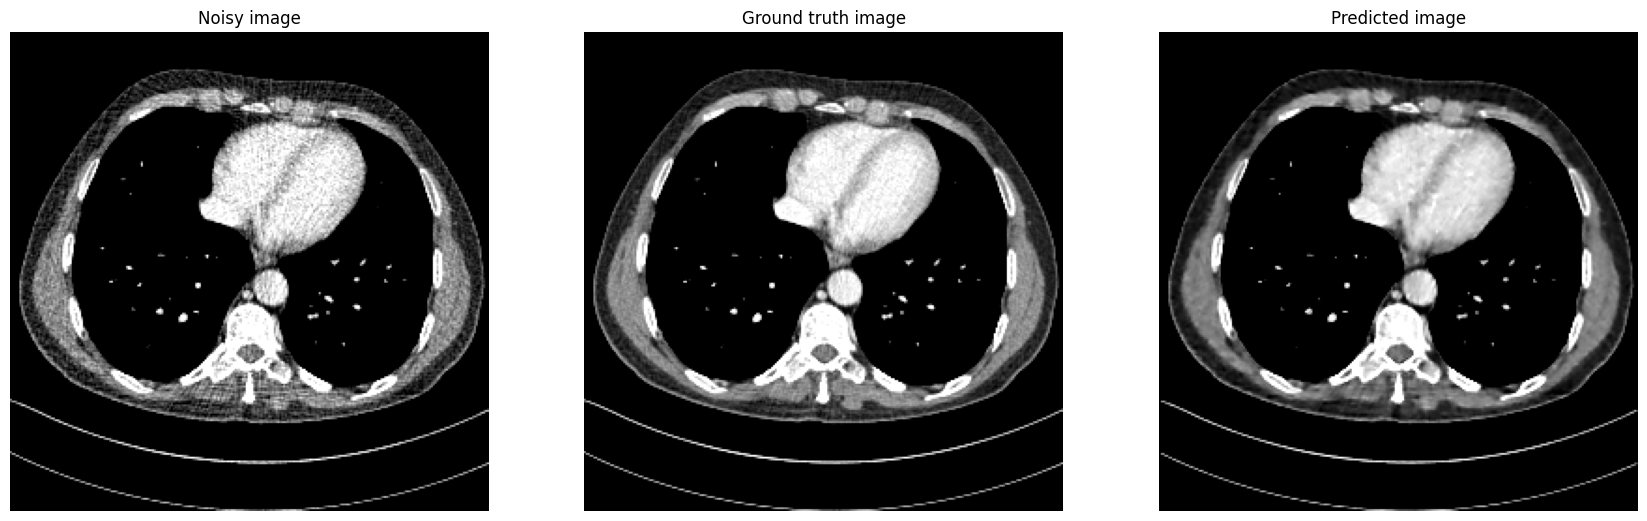

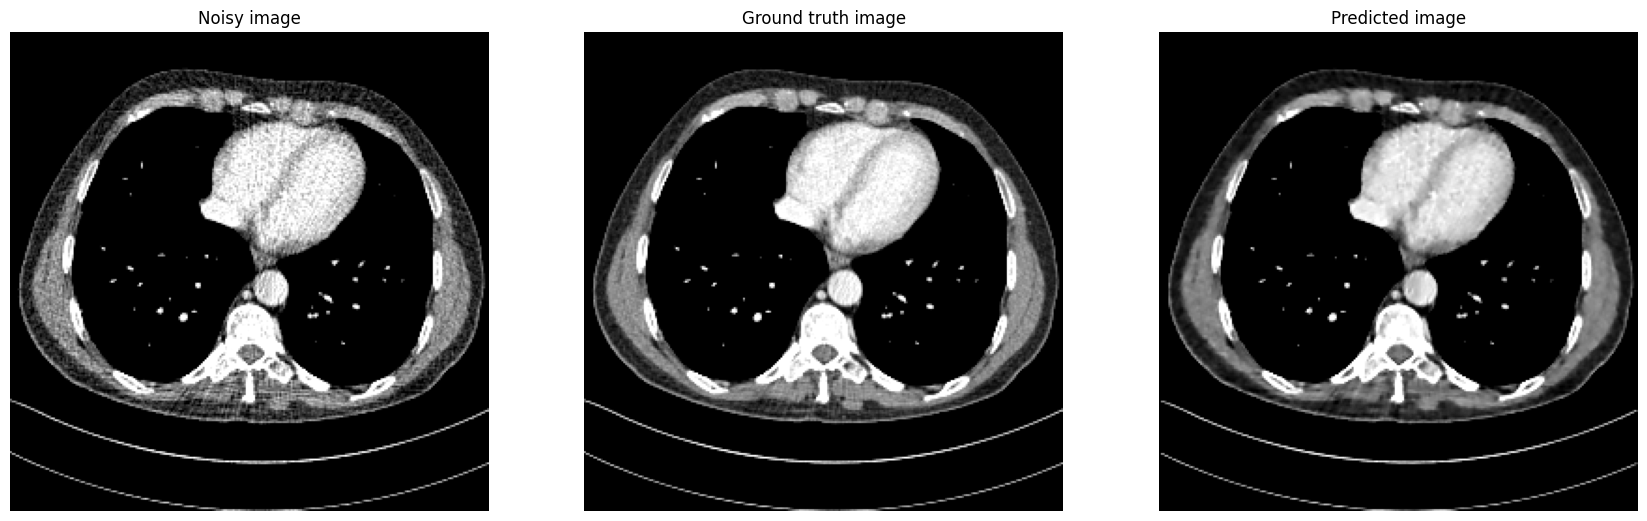

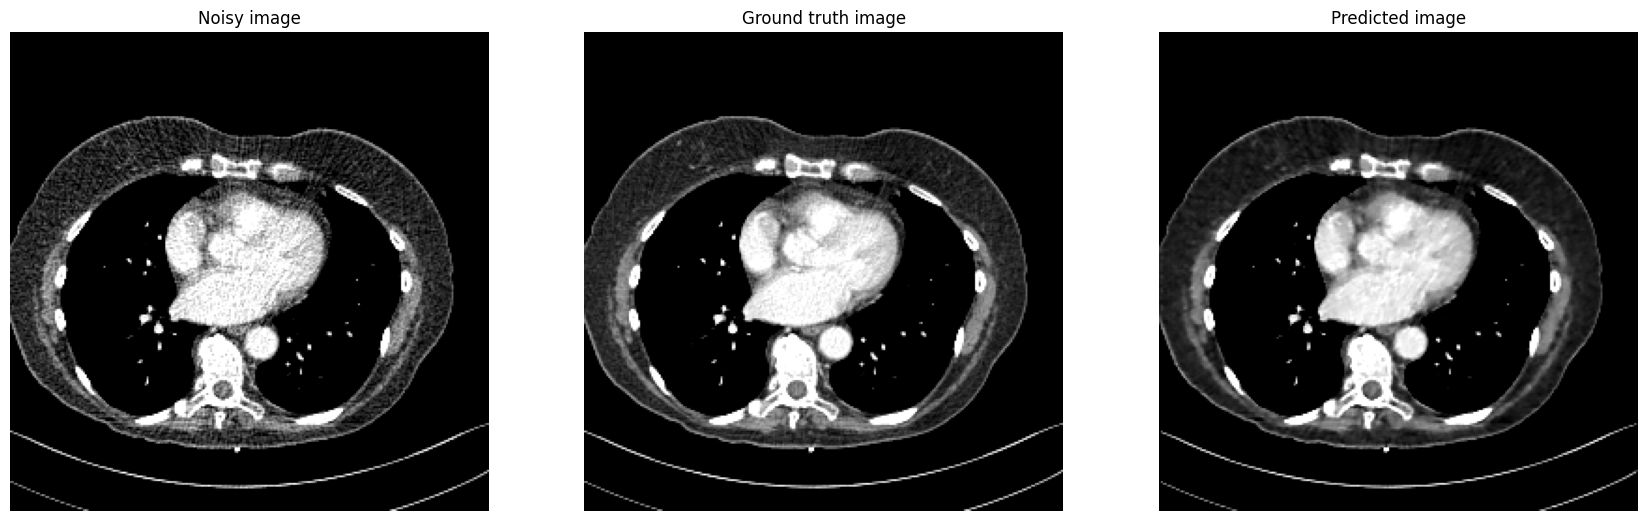

In [70]:
visualize_predictions(model, noisy_test_images, gt_test_images, len(noisy_test_images))
visualize_predictions(model, noisy_train_images, gt_train_images, len(noisy_train_images))

In [80]:
from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images)
psnr_original_mean = 0
psnr_prediction_mean = 0

print(predicted_images.shape, gt_test_images.shape)

i = 0
for gt_img, noisy_img, predicted_img in zip(gt_test_images, noisy_test_images, predicted_images):
    predicted_img=  rgb2gray(predicted_images[i])
    #predicted_img = np.expand_dims(predicted_images, axis=-1)
    
    print(gt_img.shape, predicted_img.shape)
    
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)
    i = i + 1
psnr_original_mean/=gt_test_images.shape[0]
psnr_prediction_mean/=gt_test_images.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

1/1 [==============================] - 2s 2s/step
(3, 256, 256, 3) (3, 256, 256, 1)
(256, 256, 1) (256, 256, 1)
(256, 256, 1) (256, 256, 1)
(256, 256, 1) (256, 256, 1)
Original average gt-noisy PSNR -> 44.59780844856004
Predicted average gt-predicted PSNR -> 45.48877599065173


In [88]:
from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images)
ssim_original_mean = 0
ssim_prediction_mean = 0

i = 0
for gt_img, noisy_img, predicted_img in zip(gt_test_images, noisy_test_images, predicted_images):
    predicted_img=  rgb2gray(predicted_images[i])
    i = i + 1
    print(gt_img.shape, predicted_img.shape)


    ssim_original_mean += ssim(gt_img, noisy_img,     win_size=5,  channel_axis=2, data_range=1.0)
    ssim_prediction_mean += ssim(gt_img, predicted_img, win_size=5,  channel_axis=2, data_range=1.0)

ssim_original_mean/=gt_test_images.shape[0]
ssim_prediction_mean/=gt_test_images.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)

1/1 [==============================] - 2s 2s/step
(256, 256, 1) (256, 256, 1)
(256, 256, 1) (256, 256, 1)
(256, 256, 1) (256, 256, 1)
Original average gt-noisy SSIM -> 0.9701922838037255
Predicted average gt-predicted SSIM -> 0.9855906435685623
